In [1]:
import torch
import math
import numpy as np

import torch.nn as nn

class GMM(nn.Module):
    
    
    def __init__(self, K, D):
        """
        Initializes means, variances and weights randomly
        :param K: number of gaussians
        :param D: number of features
        """
        super(GMM, self).__init__()

        self.D = D
        self.K = K
        self.mu = nn.Parameter(torch.rand(K, D))
        self.logvar = nn.Parameter(torch.rand(K))
        self.alpha = nn.Parameter(torch.empty(K).fill_(1. / K))

        self.logvarbound = 0
        self.NORM_CONST = torch.tensor(2*math.pi).log()
    
    def forward(self, X):
        """
        Compute the likelihood of each data point under each gaussians.
        :param X: design matrix (examples, features) (N,D)
        :return likelihoods: (K, examples) (K, N)
        """
        
        a = ((X[None,:,:]-self.mu[:,None,:])**2).sum(-1)
        b = self.logvar[:,None].exp()
        return (self.alpha.log()[:,None] 
                - .5*( self.D*self.NORM_CONST 
                      + self.D*self.logvar[:,None] 
                      + a/b ) )
                                          
    
    def get_posteriors(self, X):
        log_like = self.forward(X)
        log_post = log_like - self.logsumexp(log_like, dim=0, keepdim=True)
        return log_post
    
    def EM_step(self, X):
        log_post = self.get_posteriors(X)
        post = log_post.exp()
        Nk = post.sum(dim=1)
        
        self.mu.data = (post[:,:,None]*X[None,:,:]).sum(dim=1) / Nk[:,None]
        temp = log_post + ((X[None,:,:]-self.mu[:,None,:])**2).sum(dim=-1).log()
        self.logvar.data = (- Nk.log() 
                       + self.logsumexp(temp, dim=1, keepdim=False))
        
        self.alpha.data = Nk/Nk.sum()
        
    def find_solution(self, X, initialize=True, iterate=True):
        
        assert X.device==self.mu.device, 'Data stored on ' + str(X.device) + ' but model on ' + str(self.mu.device)
        
        with torch.no_grad():
            if initialize:
                m = X.size(0)
                idxs = torch.from_numpy(np.random.choice(m, self.K, replace=False)).long()
                self.mu.data = X[idxs]
                self.logvar.data = torch.empty(self.K, device=self.mu.device).fill_( (X.var() / self.K).log() )
                self.alpha.data = torch.empty(self.K, device=self.mu.device).fill_(1. / self.K)
                self.logvarbound = (X.var() / m).log()

            if iterate:
                for _ in range(500):
                    mu_prev = self.mu
                    logvar_prev = self.logvar
                    alpha_prev = self.alpha
                    self.EM_step(X)
                    self.logvar.data[self.logvar < self.logvarbound] = self.logvarbound

                    delta = torch.stack( ((mu_prev-self.mu).abs().max(),
                                (logvar_prev-self.logvar).abs().max(),
                                (alpha_prev-self.alpha).abs().max()) ).max()

                    if delta<10e-6:
                        break

    
    @staticmethod
    def logsumexp(x, dim, keepdim=False):
        """
        :param x: input data
        :param dim: dimension to sum over
        :param keepdim: whether it should squeeze that dimension
        :return:
        """
        max, _ = torch.max(x, dim=dim, keepdim=True)
        out = max.squeeze() + (x - max).exp().sum(dim=dim, keepdim=keepdim).log()
        return out

    

In [2]:
def sample(mu, var, nb_samples=500):
    """
    Return a tensor of (nb_samples, features), sampled
    from the parameterized gaussian.
    :param mu: torch.Tensor of the means
    :param var: torch.Tensor of variances (NOTE: zero covars.)
    """
    out = []
    for i in range(nb_samples):
        out += [
            torch.normal(mu, var.sqrt())
        ]
    return torch.stack(out, dim=0)

# generate some clusters
cluster1 = sample(
    torch.Tensor([2.5, 2.5]),
    torch.Tensor([1.2, .8]),
    nb_samples=500
)

cluster2 = sample(
    torch.Tensor([7.5, 7.5]),
    torch.Tensor([.75, .5]),
    nb_samples=500
)

cluster3 = sample(
    torch.Tensor([8, 1.5]),
    torch.Tensor([.6, .8]),
    nb_samples=1000
)

X = torch.cat([cluster1, cluster2, cluster3])

In [3]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

gmm = GMM(100, 2).to(device)
gmm.find_solution(X.to(device))

In [4]:
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
import seaborn as sns
from matplotlib import patches

def plot_2d_sample(sample, mu=None, sig=None):
    """
    :param sample: 
    :param mu:
    :param sig: 
    :return:
    """
    #fig = plt.figure(figsize=(5, 5))
    ax = plt.gca()
    ax.cla()
    
    sample_np = sample.numpy()
    x = sample_np[:, 0]
    y = sample_np[:, 1]
    ax.scatter(x, y)

    if (mu is not None and sig is not None):
        for i in range(mu.shape[0]):
            ellipse = patches.Ellipse( (mu[i,0], mu[i,1]) , 2*sig[i], 2*sig[i], color='r', fill=False) 
            ax.add_artist(ellipse)
    plt.axis('equal')
    plt.show()

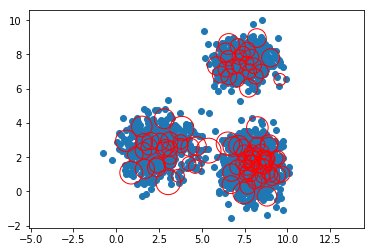

In [5]:
plot_2d_sample(X,gmm.mu, (gmm.logvar/2).exp())

In [26]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self, X, K, i=1.):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 20, 5, 1)
        self.conv2 = nn.Conv2d(20, 50, 5, 1)
        self.fc1 = nn.Linear(4*4*50, 500)
        self.fc2 = nn.Linear(500, 10)
        
        self.gmm = GMM(K, 784)
        self.gmm.find_solution(X, iterate=False)
        self.log_pz_lam = -784*torch.tensor(i).log().to(device)
        self.log_K = -torch.tensor(10.).log().to(device)
        
        
    def forward(self, x):
        batch_size = x.shape[0]
        likelihood_per_peak = self.gmm(x.view(batch_size, 784))
        like = self.gmm.logsumexp(likelihood_per_peak, 0)

        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 4*4*50)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = F.log_softmax(x, dim=1)
        
        a1 = torch.stack( (x + like[:,None], (self.log_pz_lam + self.log_K)*torch.ones_like(x) ), 0)
        b1 = self.gmm.logsumexp(a1, 0).squeeze()

        a2 = torch.stack( (like , (self.log_pz_lam)*torch.ones_like(like) ), 0)
        b2 = self.gmm.logsumexp(a2, 0).squeeze()[:,None]

        return b1-b2
        #return x
        

class NetVanilla(nn.Module):
    def __init__(self, X, K):
        super(NetVanilla, self).__init__()
        self.conv1 = nn.Conv2d(1, 20, 5, 1)
        self.conv2 = nn.Conv2d(20, 50, 5, 1)
        self.fc1 = nn.Linear(4*4*50, 500)
        self.fc2 = nn.Linear(500, 10)
        

    def forward(self, x):

        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 4*4*50)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = F.log_softmax(x, dim=1)

        return x

In [27]:
from torchvision import datasets, transforms

batch_size = 100
test_batch_size = 10


class Transpose(object):
    def __init__(self):
        pass
    def __call__(self, data):
        return data.transpose(-1,-2)

transform = transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize((0.1307,), (0.3081,))
                       ])
transform = transforms.Compose([
                           transforms.ToTensor()
                       ])

#transform = transforms.ToTensor()

train_loader = torch.utils.data.DataLoader(
        datasets.MNIST('../data', train=True, download=True, transform=transform),
        batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(
        datasets.MNIST('../data', train=False, transform=transform),
        batch_size=test_batch_size, shuffle=False)
gmm_loader = torch.utils.data.DataLoader(
        datasets.MNIST('../data', train=True, download=True, transform=transform),
        batch_size=10000, shuffle=True)

#EMNIST is rotated 90 degrees from MNIST
EMNIST_train_loader = torch.utils.data.DataLoader(
    datasets.EMNIST('../data', split='letters', download=True, train=True, 
                    transform=transforms.Compose([transform, Transpose()])),
    batch_size=batch_size, shuffle=True)

EMNIST_test_loader = torch.utils.data.DataLoader(
    datasets.EMNIST('../data', split='letters', download=True, train=False, 
                    transform=transforms.Compose([transform, Transpose()])),
    batch_size=test_batch_size, shuffle=True)

EMNIST_test_loader_digits = torch.utils.data.DataLoader(
    datasets.EMNIST('../data', split='digits', download=True, train=False, 
                    transform=transforms.Compose([transform, Transpose()])),
    batch_size=test_batch_size, shuffle=True)

X_MNIST = enumerate(gmm_loader).__next__()[1][0].view(gmm_loader.batch_size, 784)

In [35]:
model = Net(X_MNIST, 1000).to(device)
#model.gmm.find_solution(X_MNIST)
#model2 = NetVanilla(X_MNIST, 30).to(device)
#model.gmm.find_solution(X_MNIST.to(device))
mu1 = model.gmm.mu.data
mu1.max()
model.gmm.logvar

Parameter containing:
tensor([-9.2590, -9.2590, -9.2590, -9.2590, -9.2590, -9.2590, -9.2590, -9.2590,
        -9.2590, -9.2590, -9.2590, -9.2590, -9.2590, -9.2590, -9.2590, -9.2590,
        -9.2590, -9.2590, -9.2590, -9.2590, -9.2590, -9.2590, -9.2590, -9.2590,
        -9.2590, -9.2590, -9.2590, -9.2590, -9.2590, -9.2590, -9.2590, -9.2590,
        -9.2590, -9.2590, -9.2590, -9.2590, -9.2590, -9.2590, -9.2590, -9.2590,
        -9.2590, -9.2590, -9.2590, -9.2590, -9.2590, -9.2590, -9.2590, -9.2590,
        -9.2590, -9.2590, -9.2590, -9.2590, -9.2590, -9.2590, -9.2590, -9.2590,
        -9.2590, -9.2590, -9.2590, -9.2590, -9.2590, -9.2590, -9.2590, -9.2590,
        -9.2590, -9.2590, -9.2590, -9.2590, -9.2590, -9.2590, -9.2590, -9.2590,
        -9.2590, -9.2590, -9.2590, -9.2590, -9.2590, -9.2590, -9.2590, -9.2590,
        -9.2590, -9.2590, -9.2590, -9.2590, -9.2590, -9.2590, -9.2590, -9.2590,
        -9.2590, -9.2590, -9.2590, -9.2590, -9.2590, -9.2590, -9.2590, -9.2590,
        -9.2590, -

In [23]:
def train(model, device, train_loader, optimizer, epoch, adv_loader):
    model.train()
    min_loss = torch.tensor(10.).log()
    #for batch_idx, (data, target) in enumerate(train_loader):
    for ((batch_idx, (data, target)), (_, (data_adv, _))) in zip(enumerate(train_loader),enumerate(adv_loader)):
        data, target = data.to(device), target.to(device)
        data_adv = data_adv.to(device)
        optimizer.zero_grad()
        output = model(data)
        
        input_rand = torch.rand(train_loader.batch_size,1,28,28).to(device)
        #output_rand = model(input_rand)
        output_rand = model(data_adv)

        loss = F.nll_loss(output, target) - output_rand.sum()/(10*train_loader.batch_size)
        #loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))


def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    av_conf = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)

            test_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss
            c, pred = output.max(1, keepdim=True) # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()
            av_conf += c.exp().sum().item()
            
    test_loss /= len(test_loader.dataset)
    av_conf /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%), Ave. Confidence: {:.0f}%\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset), 100. * av_conf))

In [25]:
import torch.optim as optim

lr = .001
momentum = .9


optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)
#optimizer2 = optim.SGD(model2.parameters(), lr=lr, momentum=momentum)
for epoch in range(1):
    train(model, device, train_loader, optimizer, epoch, EMNIST_train_loader)
    #train(model2, device, train_loader, optimizer2, epoch, EMNIST_train_loader)

Train Epoch: 0 [0/60000 (0%)]	Loss: 4.607128
Train Epoch: 0 [10000/60000 (17%)]	Loss: 4.606097
Train Epoch: 0 [20000/60000 (33%)]	Loss: 4.605094
Train Epoch: 0 [30000/60000 (50%)]	Loss: 4.605991
Train Epoch: 0 [40000/60000 (67%)]	Loss: 4.605469


KeyboardInterrupt: 

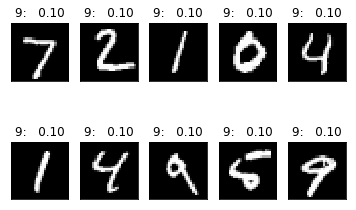

In [206]:
def unnormalize(tensor, mean, std):

    for t, m, s in zip(tensor, mean, std):
        t.mul_(s).add_(m)
        # The normalize code -> t.sub_(m).div_(s)
    return tensor

data = enumerate(test_loader).__next__()[1][0]
y = model(data.to(device))

for i in range(10):
    plt.subplot(2,5,i+1)
    plt.title(str(y.argmax(1)[i].item()) + ":   %.2f" % y[i].max().exp().item())
    plt.imshow(unnormalize(data, (0.1307,), (0.3081,) )[i].squeeze(), cmap='gray', interpolation='none')
    plt.xticks([])
    plt.yticks([])

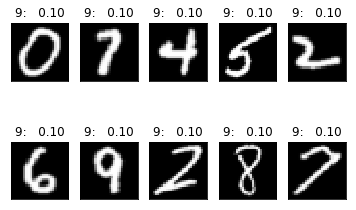

In [205]:
def unnormalize(tensor, mean, std):

    for t, m, s in zip(tensor, mean, std):
        t.mul_(s).add_(m)
        # The normalize code -> t.sub_(m).div_(s)
    return tensor

data = enumerate(EMNIST_test_loader_digits).__next__()[1][0]
y = model(data.to(device))

for i in range(10):
    plt.subplot(2,5,i+1)
    plt.title(str(y.argmax(1)[i].item()) + ":   %.2f" % y[i].max().exp().item())
    plt.imshow(unnormalize(data, (0.1307,), (0.3081,) )[i].squeeze(), cmap='gray', interpolation='none')
    plt.xticks([])
    plt.yticks([])

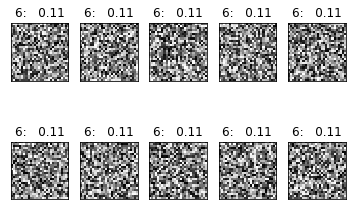

In [16]:
import matplotlib.pyplot as plt

x = torch.rand(10,1,28,28).to(device)
y = model(x)
x = x.cpu()
fig = plt.figure()
for i in range(10):
    plt.subplot(2,5,i+1)
    plt.title(str(y.argmax(1)[i].item()) + ":   %.2f" % y[i].max().exp().item())
    plt.imshow(x.view((10, 1, 28, 28))[i].squeeze(), cmap='gray', interpolation='none')
    plt.xticks([])
    plt.yticks([])

In [139]:
test(model, device, test_loader)


Test set: Average loss: 0.7974, Accuracy: 8093/10000 (81%), Ave. Confidence: 59%



In [140]:
test(model, device, EMNIST_test_loader_digits)


Test set: Average loss: 1.4339, Accuracy: 23327/40000 (58%), Ave. Confidence: 37%



In [96]:
test(model2, device, test_loader)


Test set: Average loss: 0.3818, Accuracy: 9467/10000 (95%), Ave. Confidence: 74%



In [97]:
test(model2, device, EMNIST_test_loader_digits)


Test set: Average loss: 1.1050, Accuracy: 29378/40000 (73%), Ave. Confidence: 45%



In [107]:
print(model.gmm.mu[0].max().item())

0.9977548122406006


In [90]:
mu1[0].max().item()

0.9977548122406006

In [66]:
model.gmm.parameters().__next__()

Parameter containing:
tensor([[0.5834, 0.6609, 0.1568,  ..., 0.2830, 0.8090, 0.1345],
        [0.2466, 0.5433, 0.8761,  ..., 0.0734, 0.6454, 0.5918],
        [0.0334, 0.3833, 0.1505,  ..., 0.4978, 0.4704, 0.1261],
        ...,
        [0.4401, 0.4736, 0.8255,  ..., 0.5408, 0.8884, 0.8873],
        [0.0602, 0.3778, 0.0906,  ..., 0.9051, 0.0199, 0.5290],
        [0.4124, 0.6566, 0.9070,  ..., 0.3148, 0.1679, 0.5927]],
       requires_grad=True)

In [72]:
model.gmm.mu.sum().item()

3816.41015625

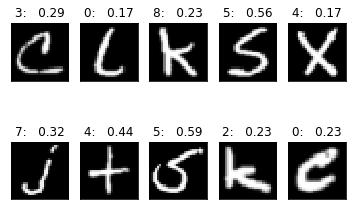

In [214]:
def unnormalize(tensor, mean, std):

    for t, m, s in zip(tensor, mean, std):
        t.mul_(s).add_(m)
        # The normalize code -> t.sub_(m).div_(s)
    return tensor

data = enumerate(EMNIST_test_loader).__next__()[1][0]
y = model(data.to(device))

for i in range(10):
    plt.subplot(2,5,i+1)
    plt.title(str(y.argmax(1)[i].item()) + ":   %.2f" % y[i].max().exp().item())
    plt.imshow(unnormalize(data, (0.1307,), (0.3081,) )[i].squeeze(), cmap='gray', interpolation='none')
    plt.xticks([])
    plt.yticks([])

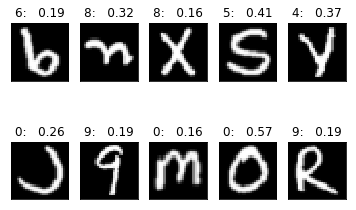

In [106]:
def unnormalize(tensor, mean, std):

    for t, m, s in zip(tensor, mean, std):
        t.mul_(s).add_(m)
        # The normalize code -> t.sub_(m).div_(s)
    return tensor

data = enumerate(EMNIST_test_loader).__next__()[1][0]
y = model2(data.to(device))

for i in range(10):
    plt.subplot(2,5,i+1)
    plt.title(str(y.argmax(1)[i].item()) + ":   %.2f" % y[i].max().exp().item())
    plt.imshow(unnormalize(data, (0.1307,), (0.3081,) )[i].squeeze(), cmap='gray', interpolation='none')
    plt.xticks([])
    plt.yticks([])

In [108]:
data = enumerate(train_loader).__next__()[1][0]

In [111]:
data.max()-data.min()

tensor(3.2457)

In [114]:
model.log_pz_lam

tensor(-861.3121)

In [121]:
model.log_pz_lam

tensor(-0.)

In [179]:
print(model.gmm.mu[0].max().item())

2.2694740295410156


In [180]:
print(mu1[0].max().item())

2.2694740295410156


In [146]:
X_MNIST.max()-X_MNIST.min()

tensor(3.2457)

tensor(-0.4242)

In [12]:
((batch_idx, (data, target)), (_, (data_adv, _))) = zip(enumerate(train_loader),enumerate(EMNIST_train_loader)).__next__()

data, target = data.to(device), target.to(device)
data_adv = data_adv.to(device)

output = model(data)

input_rand = torch.rand(train_loader.batch_size,1,28,28).to(device)
#output_rand = model(input_rand)
output_rand = model(data_adv)

loss = F.nll_loss(output, target) - output_rand.sum()/(10*train_loader.batch_size)
#loss = F.nll_loss(output, target)
loss.backward()

In [199]:
model.gmm.mu.grad.abs().max()

tensor(1.1461e-39)

In [200]:
model.gmm.mu.abs().max()

tensor(2.7200, grad_fn=<MaxBackward1>)

In [203]:
model.gmm.mu.max()

tensor(2.7200, grad_fn=<MaxBackward1>)

In [21]:
model.gmm(data_adv.view(100, 784)).max()

tensor(-2450.0173, grad_fn=<MaxBackward1>)

In [22]:
model.gmm(data.view(100, 784)).max()

tensor(-2449.5859, grad_fn=<MaxBackward1>)

In [23]:
model.gmm(torch.rand(100,784)).max()

tensor(-2454.0696, grad_fn=<MaxBackward1>)

In [50]:
l = []
for i in range(100)
    a = X_MNIST[5]-model.gmm.mu[0]

In [51]:
a.norm()

tensor(25.3999, grad_fn=<NormBackward0>)

In [54]:
model.gmm.logvar[0:10].exp()

tensor([362.0951, 392.7061, 112.4149, 281.5462, 361.1005, 157.4860, 297.7184,
        286.1122, 310.3561, 188.8785], grad_fn=<ExpBackward>)

In [56]:
model.gmm.mu.shape

torch.Size([100, 784])

In [69]:
a = torch.norm(X_MNIST[:,None,:]-model.gmm.mu[None,:,:], dim=2)
b = torch.norm(torch.rand(2000,1,784)-model.gmm.mu[None,:,:], dim=2)

In [30]:
def plot_2d_sample2(sample, mu=None, sig=None):
    """
    :param sample: 
    :param mu:
    :param sig: 
    :return:
    """
    #fig = plt.figure(figsize=(5, 5))
    ax = plt.gca()
    ax.cla()
    
    sample_np = sample.numpy()
    x = sample_np[:, 344]
    y = sample_np[:, 345]
    ax.scatter(x, y)

    if (mu is not None and sig is not None):
        for i in range(mu.shape[0]):
            ellipse = patches.Ellipse( (mu[i,0], mu[i,1]) , 2*sig[i], 2*sig[i], color='r', fill=False) 
            ax.add_artist(ellipse)
    plt.axis('equal')
    plt.show()

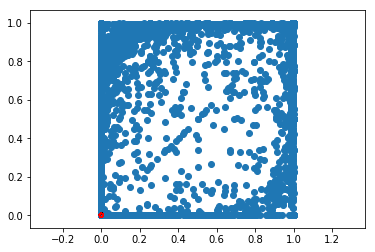

In [31]:
plot_2d_sample2(X_MNIST,model.gmm.mu, (model.gmm.logvar/2).exp())

In [41]:
model.gmm.mu[:][[344,345]]

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], grad_fn=<IndexBackward>)